# Fatal Police Shooting in the US EDA

## Finding the goals

In this notebook, we will analyze the dataset of fatal police shooting in the US. In particular we will check trends and relationships among the data in order to understand the reasons of the increasing popular opinion about the unreliability and racism of police officers. This also caused the foundation of the political and social movement "Black Lives Matter" in 2013.

## Data selection

In [1]:
# Import necessary libs
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from pathlib import Path as path
import warnings
warnings.filterwarnings("ignore")
import gender_guesser.detector as gender
from IPython.display import Image, display
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from functools import reduce

# Check files in current directory
current_path = path.cwd()
import os
for dirname, _, filenames in os.walk(current_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))            

C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\AlbertoAgròDataVis.ipynb
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\Clesslynn Jane Crawford.png
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\fatal-police-shootings-agencies.csv
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\fatal-police-shootings-data.csv
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\MedianHouseholdIncome2015.csv
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\PercentagePeopleBelowPovertyLevel.csv
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\PercentOver25CompletedHighSchool.csv
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\PopulationByCity.csv
C:\Users\AAgro\Notebook\2. Data Manipulation and Visualization\Progetto EDA\ShareRaceByCity.csv
C:\Users\AAgro\Notebook\2. Data Manipulation and 

In [2]:
# Read data
df_shoot = pd.read_csv(os.path.join(current_path, 'fatal-police-shootings-data.csv'))
df_agencies = pd.read_csv(os.path.join(current_path, 'fatal-police-shootings-agencies.csv'))      
df_population = pd.read_csv(os.path.join(current_path, 'PopulationByCity.csv'))
df_sharebycity = pd.read_csv(os.path.join(current_path, 'ShareRaceByCity.csv'))
df_income = pd.read_csv(os.path.join(current_path, 'MedianHouseholdIncome2015.csv'),encoding='unicode_escape')
df_poverty = pd.read_csv(os.path.join(current_path, 'PercentagePeopleBelowPovertyLevel.csv'),encoding='unicode_escape')
df_highschool = pd.read_csv(os.path.join(current_path, 'PercentOver25CompletedHighSchool.csv'),encoding='unicode_escape')

In [3]:
# Rename columns to concatenate them
df_shoot = df_shoot.rename(columns={'agency_ids':'agency_id'})
df_agencies = df_agencies.rename(columns={'id':'agency_id'})
df_agencies = df_agencies.rename(columns={'name':'agency_name'})
df_agencies['agency_id'] = df_agencies['agency_id'].astype(str)

In [4]:
# Concatenate dataframes
df = df_shoot.merge(df_agencies, how="left").set_index('date')

## Data cleaning

In [5]:
# Check null values
df.isnull().sum()

id                               0
threat_type                     39
flee_status                   1175
armed_with                     210
city                            54
county                        4856
state                            0
latitude                       980
longitude                      980
location_precision             980
name                           573
age                            600
gender                          47
race                          1390
race_source                   1368
was_mental_illness_related       0
body_camera                      0
agency_id                        2
agency_name                    570
type                           570
oricodes                       663
total_shootings                570
dtype: int64

In [6]:
#--- Handling missing values ---#

# Replace null values with unknown
df['threat_type'].fillna('unknown', inplace=True)
df['flee_status'].fillna('unknown', inplace=True)
df['armed_with'].fillna('unknown', inplace=True)
df['name'].fillna('unknown', inplace=True)
df['agency_name'].fillna('unknown', inplace=True)
df['agency_id'].fillna('not_available', inplace=True)
df['latitude'].fillna('not_available', inplace=True)
df['longitude'].fillna('not_available', inplace=True)

# Drop null values 
df = df.dropna(subset=['city'])
df = df.dropna(subset=['race'])
df = df.dropna(subset=['gender'])

# Replace null ages with mean
df['age'].fillna(int(df['age'].mean()), inplace=True)

# Drop unnecessary columns
df = df.drop(['location_precision'],axis="columns")
df = df.drop(['race_source'],axis="columns")
df = df.drop(['county'],axis="columns")
df = df.drop(['type'],axis="columns")
df = df.drop(['oricodes'],axis="columns")
df = df.drop(['total_shootings'],axis="columns")

In [7]:
# Check null values again
df.isnull().sum()

id                            0
threat_type                   0
flee_status                   0
armed_with                    0
city                          0
state                         0
latitude                      0
longitude                     0
name                          0
age                           0
gender                        0
race                          0
was_mental_illness_related    0
body_camera                   0
agency_id                     0
agency_name                   0
dtype: int64

## Data transformation

In [8]:
# Replace race code with description
replacing = {'W':'White', 'B':'Black', 'H':'Hispanic','A':'Asian','N':'Native','O':'Other', 'B;H':'Other'}
df['race'] = df['race'].replace(replacing)

In [9]:
# Create column year from date
df.index = pd.to_datetime(df.index)
df['year'] = df.index.year

In [10]:
# Assign multiple string to agency which has more than one id
for index, row in df.iterrows():
    if row['agency_name'] == 'unknown' and row['agency_id'] != 'not_available' and len(row['agency_id']) > 5:
        row['agency_name'] = 'multiple'

In [11]:
# Replace weapons with just yes or no
list_armed = {}
for i in df["armed_with"].unique():
    if i == "unarmed":
        list_armed[i] = "no"
    elif i == "unknown":
        pass
    else:
        list_armed[i] = "yes"
        
df["armed_with"] = df["armed_with"].replace(list_armed)
df = df.rename(columns= {'armed_with':'armed'})

# Replace threat_level with just yes or no
list_threat = {}
for i in df["threat_type"].unique():
    if i == "undetermined":
        list_threat[i] = "unknown"
    elif i == "unknown" or i == 'accident':
        pass
    else:
        list_threat[i] = "yes"
        
df["threat_type"] = df["threat_type"].replace(list_threat)
df = df.rename(columns= {'threat_type':'threat'})

# Replace flee_status with just yes or no
list_flee = {}
for i in df["flee_status"].unique():
    if i == "not":
        list_flee[i] = "no"
    elif i == "unknown":
        pass
    else:
        list_flee[i] = "yes"
        
df["flee_status"] = df["flee_status"].replace(list_flee)

In [12]:
# Create new dataframe with sum of population per state
df_popbystate = pd.DataFrame(df_population.groupby('state')['population'].sum())

In [13]:
# Set share columns' to numeric and rename "Geographic area" in order to merge with population
cols = ['share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']
df_sharebycity[cols] = df_sharebycity[cols].apply(pd.to_numeric, errors='coerce')
df_sharebycity = df_sharebycity.rename(columns={'Geographic area':'state'})

In [14]:
# Create new dataframe with share by state
df_sharebystate = df_sharebycity.groupby("state")[cols].mean().round(2)

In [15]:
# Merge population and share dataframes
df2 = pd.merge(df_popbystate, df_sharebystate, left_index=True, right_index=True)

In [16]:
# Create new dataframe with shots count by race
df_casesbyrace = df.groupby(['state']).apply(lambda x: pd.Series(dict(
    white_count=(x.race == 'White').sum(),
    black_count=(x.race == 'Black').sum(),
    asian_count=(x.race == 'Asian').sum(),
    hispanic_count=(x.race == 'Hispanic').sum(),
    other_count=(x.race == 'Other').sum(),
    native_count=(x.race == 'Native').sum(),
    total_count=x.id.count()
)))

In [17]:
# Create column "percentage" in order to calculate the shots in proportion to population
df_casesbyrace['percentage'] = df_casesbyrace.total_count / df2.population 

In [18]:
# Sorting
df_casesbyrace = df_casesbyrace.sort_values(['percentage'], ascending= False)
df_casesbyrace.reset_index(inplace = True)

In [19]:
# Merge first two dfs about domographic data
dfx = pd.merge(df_income, df_poverty, left_on=['Geographic Area', 'City'], right_on=['Geographic Area', 'City'], how='inner')
df3 = pd.merge(dfx, df_highschool, left_on=['Geographic Area', 'City'], right_on=['Geographic Area', 'City'], how='inner')
df3 = df3.rename(columns= {'Geographic Area':'state'})
df3 = df3.rename(columns= {'City':'city'})
df3 = df3.rename(columns= {'Median Income':'median_income'})
df3 = df3.dropna(subset=['median_income'])

In [20]:
# Update cols to numeric
cols5= ['median_income','poverty_rate','percent_completed_hs']
df3[cols5] = df3[cols5].apply(pd.to_numeric, errors='coerce')
df_final = df3.groupby('state')[cols5].mean().round(2)

In [21]:
# Merge the 3rd df
df5 = pd.merge(df_final, df_casesbyrace, left_on=['state'], right_on=['state'], how='inner')

## Data exploration

In [22]:
# Df shoots
df.head(3)

,id,threat,flee_status,armed,city,state,latitude,longitude,name,age,gender,race,was_mental_illness_related,body_camera,agency_id,agency_name,year
date,,,,,,,,,,,,,,,,,
2015-01-02,3,yes,no,yes,Shelton,WA,47.246826,-123.121592,Tim Elliot,53.0,male,Asian,True,False,73,Mason County Sheriff's Office,2015
2015-01-02,4,yes,no,yes,Aloha,OR,45.487421,-122.891696,Lewis Lee Lembke,47.0,male,White,False,False,70,Washington County Sheriff's Office,2015
2015-01-03,5,yes,no,no,Wichita,KS,37.694766,-97.280554,John Paul Quintero,23.0,male,Hispanic,False,False,238,Wichita Police Department,2015


In [23]:
df['threat'].value_counts()

yes         7001
unknown      249
accident      49
Name: threat, dtype: int64

After data transformation, this feature describes the shots due to threats. We will analyze the percentage of threat for each race.

In [24]:
df['armed'].value_counts()

yes        6528
no          472
unknown     299
Name: armed, dtype: int64

After data transformation, this feature describes if the victim was armed, as we don't want to know what weapon was owned. We just want to check the proportion of armed victims for each race.

In [25]:
df['state'].value_counts().nlargest(5)

CA    968
TX    662
FL    488
AZ    314
GA    274
Name: state, dtype: int64

This feature shows us the top-5 states for shots count. We will analyze shots count for every state normalizing data using population data, in order to get percentage of shots according to population.

In [26]:
df['race'].value_counts()

White       3733
Black       1975
Hispanic    1308
Asian        146
Native       115
Other         22
Name: race, dtype: int64

At last but not least, well, most important feature: race. We will check all columns grouping by race, normalizing for population as well.

In [27]:
# Describe age values
df['age'].describe()

count    7299.000000
mean       36.878202
std        12.561892
min         2.000000
25%        27.000000
50%        35.000000
75%        45.000000
max        91.000000
Name: age, dtype: float64

In [28]:
# Df population and population shares
df2.head(3)

,population,share_white,share_black,share_native_american,share_asian,share_hispanic
state,,,,,,
AK,387478.0,45.65,0.57,45.86,1.39,2.15
AL,2750534.0,72.51,23.32,0.66,0.48,2.98
AR,1616531.0,78.45,16.30,0.76,0.48,4.27


In [29]:
# Df counts by race
df_casesbyrace.head(3)

,state,white_count,black_count,asian_count,hispanic_count,other_count,native_count,total_count,percentage
0,AK,31,3,2,0,0,12,48,0.000124
1,MT,36,1,0,1,0,11,49,0.000109
2,NM,35,5,2,97,1,4,144,0.000096


We will analyze the correlation about the above 2 dataframes, in order to understand how shots are related to the total population and its shares.

In [30]:
# Df demographic data
df5.head(3)

,state,median_income,poverty_rate,percent_completed_hs,white_count,black_count,asian_count,hispanic_count,other_count,native_count,total_count,percentage
0,AK,52099.59,19.85,84.63,31,3,2,0,0,12,48,0.000124
1,AL,40577.31,20.65,80.30,90,42,0,4,0,0,136,0.000049
2,AR,35593.41,22.96,79.95,67,32,2,0,0,0,101,0.000062


In [31]:
df5.describe()

,median_income,poverty_rate,percent_completed_hs,white_count,black_count,asian_count,hispanic_count,other_count,native_count,total_count,percentage
count,51.000000,51.000000,51.000000,51.000000,51.00000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,51936.828039,16.247647,86.476863,73.196078,38.72549,2.862745,25.647059,0.431373,2.254902,143.117647,0.000044
std,11288.244174,4.550299,4.354604,65.292578,43.69214,6.808875,70.874205,1.300075,3.892779,167.330409,0.000029
min,35002.100000,8.190000,75.690000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000004
25%,42899.005000,12.610000,82.635000,30.500000,5.50000,0.000000,1.000000,0.000000,0.000000,48.000000,0.000026
50%,49811.310000,15.490000,88.230000,56.000000,25.00000,1.000000,5.000000,0.000000,1.000000,113.000000,0.000036
75%,59765.825000,19.900000,90.050000,96.000000,58.00000,2.000000,13.000000,0.000000,2.000000,154.000000,0.000065
max,80584.410000,26.880000,92.400000,292.000000,173.00000,41.000000,449.000000,8.000000,16.000000,968.000000,0.000124


We will analyze the distribution of demographic data and the correlation among them.

## Data visualization

Why was a 2 years old child shot?

In [32]:
# Check data about 2 years old child
df[df['age'] == 2]

,id,threat,flee_status,armed,city,state,latitude,longitude,name,age,gender,race,was_mental_illness_related,body_camera,agency_id,agency_name,year
date,,,,,,,,,,,,,,,,,
2022-03-26,7981,accident,unknown,no,Baxter Springs,KS,37.023676,-94.735504,Clesslynn Jane Crawford,2.0,female,White,False,False,2548,unknown,2022


Unfortunately a bad accident happened in March 2022. Below the news.

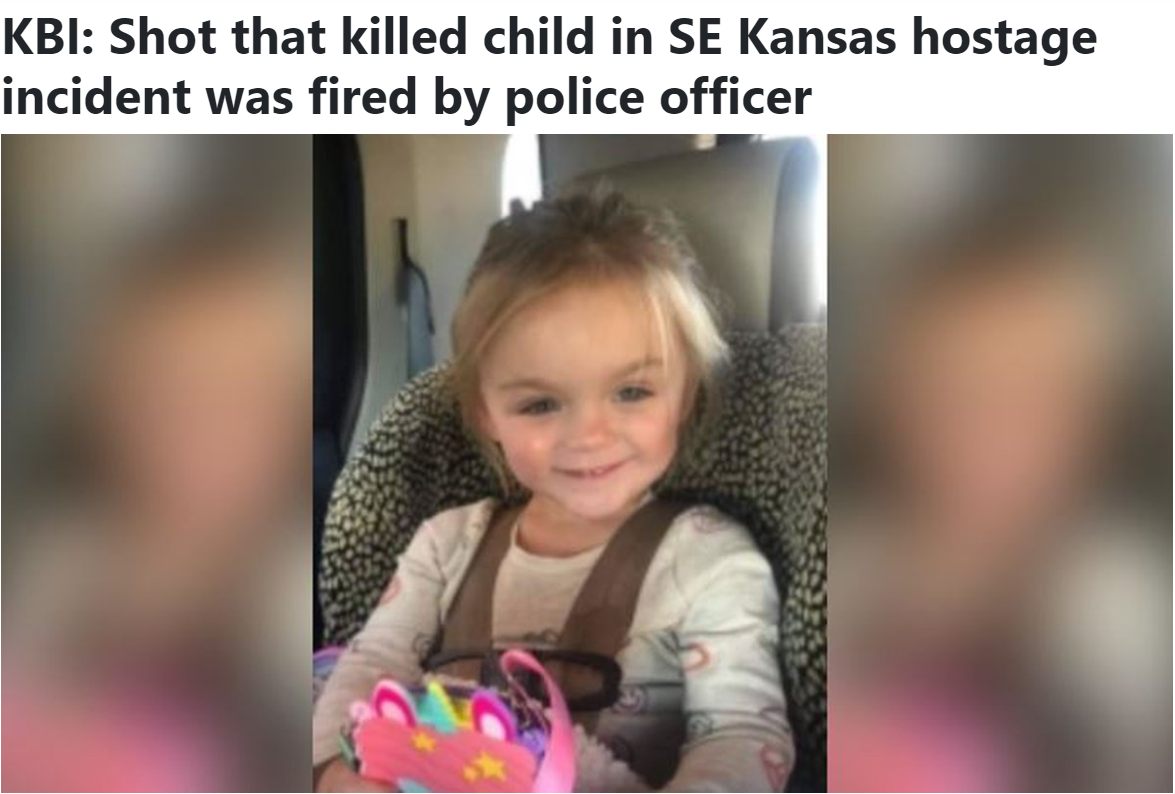

In [33]:
display(Image('Clesslynn Jane Crawford.png', width=700))

Let's start now with some data visualization.

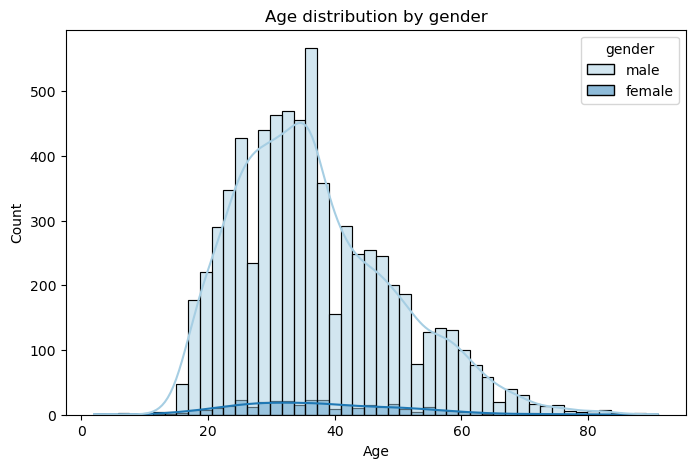

In [34]:
# Plot shots by gender
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="age", hue="gender", palette="Paired", kde=True)
plt.title('Age distribution by gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The graph, showing the shots distribution by age, has a normal distribution with mean staying around 37. It also shows that the number of males is extremely larger than females.

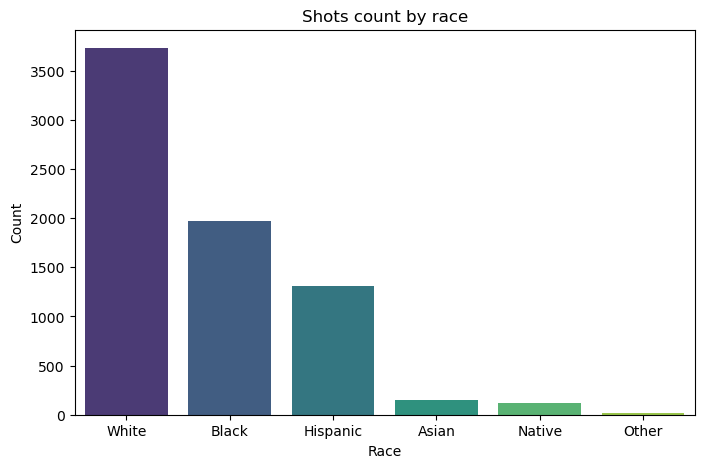

In [35]:
# Plot shots by race
plt.figure(figsize=(8, 5))
sns.countplot(x='race', data=df, palette='viridis', order=df['race'].value_counts().index)
plt.title('Shots count by race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.show()

The graph shows that most of the shots involved white people, following black, hispanic, asian, native and other race. We will discuss further this graph later with the analysis of the US population.

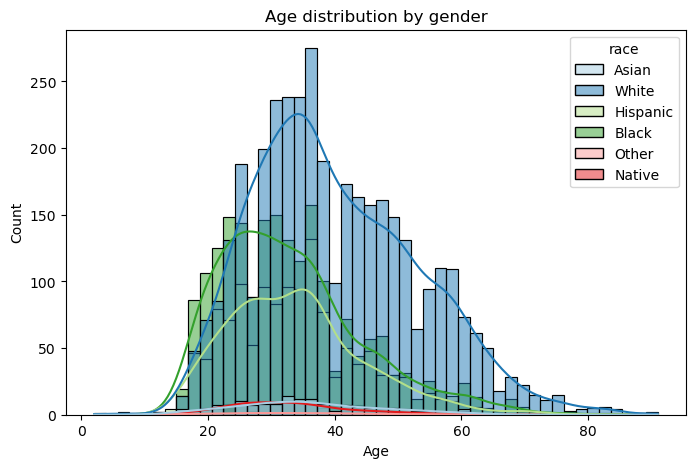

In [36]:
# Plot shots by race and age
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="age", hue="race", palette="Paired", kde=True)
plt.title('Age distribution by gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Let's check now the shots distribution by gender.

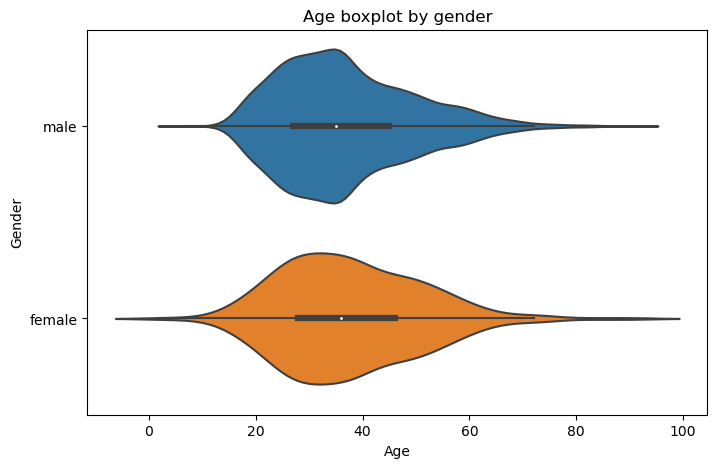

In [37]:
# Plot shots distribution by gender with boxplot
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x = 'age', y = 'gender')
plt.title('Age boxplot by gender')
plt.xlabel('Age')
plt.ylabel('Gender')
plt.show()

We can see the distribution of ages by gender is quite equal for both males and females.

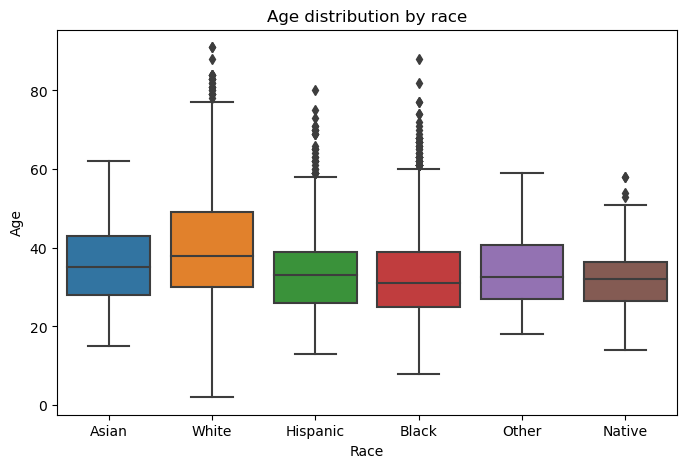

In [38]:
# Plot shots distribution by race
plt.figure(figsize=(8, 5))
sns.boxplot(x='race', y= 'age', data= df)
plt.title('Age distribution by race')
plt.xlabel('Race')
plt.ylabel('Age')
plt.show()

Apparently we have a similar distribution of age by race, while there are several outliers for white, hispanic, black race and few ones for native race.

Let's analyze now geographical data.

In [39]:
# Get first 5 agencies
top5 = df.groupby(['state'])['agency_name'].value_counts().nlargest(5)
top5

state  agency_name                             
CA     Los Angeles Police Department               109
AZ     Phoenix Police Department                    89
CA     Los Angeles County Sheriff's Department      89
TX     Houston Police Department                    57
NV     Las Vegas Metropolitan Police Department     56
Name: agency_name, dtype: int64

This is our top-5 police agencies involved in fatal shots. We can see that two states of the top-5 belongs to California. Let's check the shots by state then.

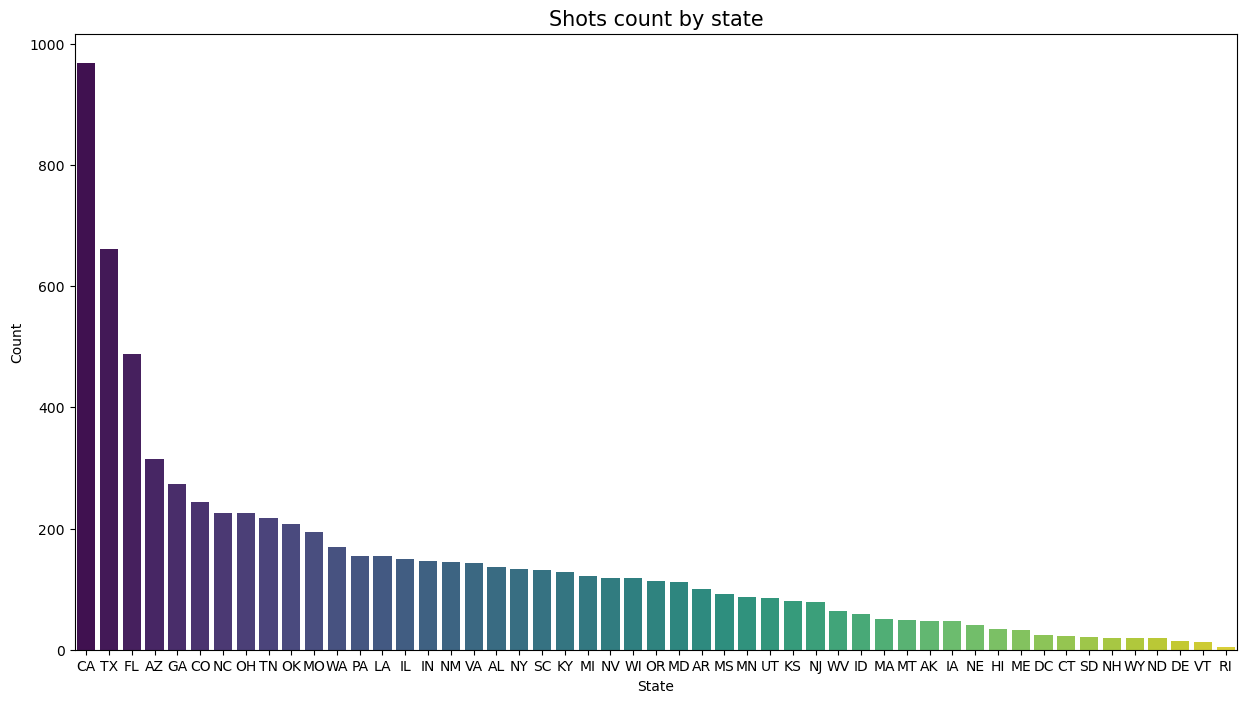

In [40]:
# Plot count by state
plt.figure(figsize=(15, 8))
sns.countplot(x='state', data=df, palette='viridis', order=df['state'].value_counts().index)
plt.title('Shots count by state', fontsize=15)
plt.xlabel('State')
plt.ylabel('Count')
plt.show()

As we could imagine, California owns the record for shots. It follows Texas, Florida, Arizona and Georgia. However, this needs to be reviewed analyzing the total population as well.

(0.0, 75.0)

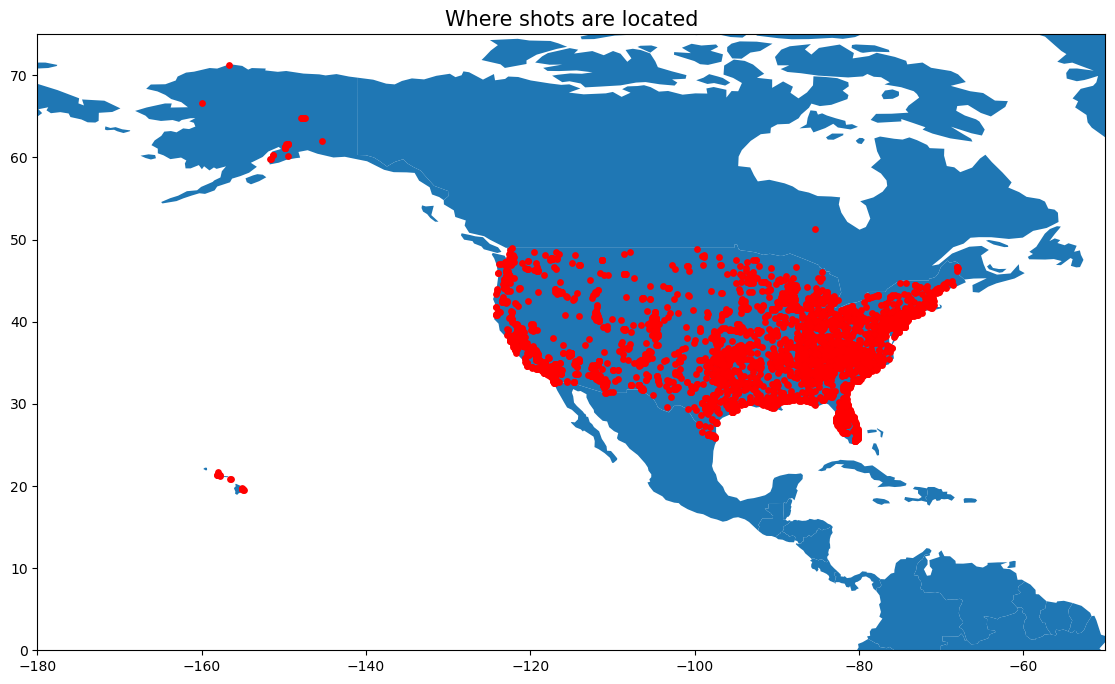

In [41]:
# Plot shots in the US map
df_geo = df.drop(df[df.longitude == 'not_available'].index)
df_geo = df.drop(df[df.latitude == 'not_available'].index)

geometry = [Point(xy) for xy in zip(df_geo['longitude'], df_geo['latitude'])]
gdf = GeoDataFrame(df_geo, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(15, 8))
gdf.plot(ax=ax, marker='o', color='red', markersize=15)
plt.title('Where shots are located', fontsize=15)
ax.set_xlim(-180, -50)
ax.set_ylim(0, 75)

From the graph above we can notice that most of the cases are located on the west coast and the center-east side. 

We can now check the trend of cases from 2015.

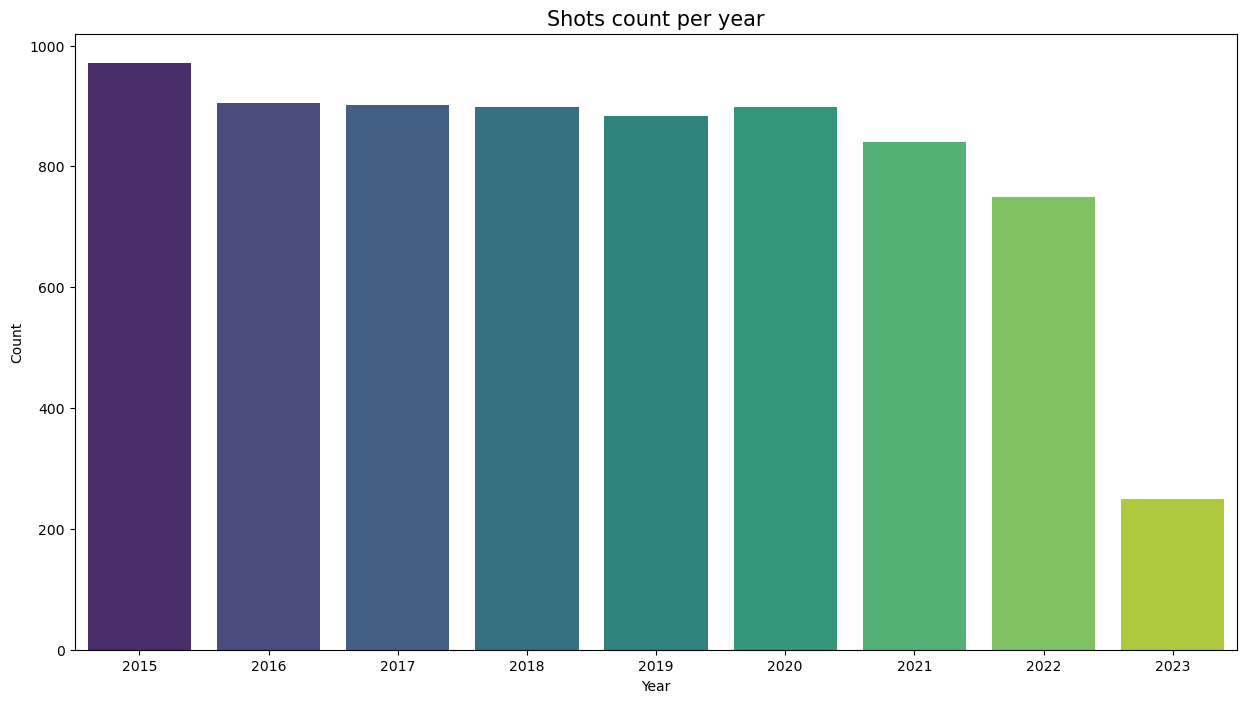

In [42]:
# Plot shots by year
plt.figure(figsize=(15,8))
sns.countplot(x='year', data=df, palette='viridis')
plt.title('Shots count per year', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Fortunately the cases are decreasing from 2015, the current year cannot be completely valid for the analysis as still ongoing, but we could check the count of cases of previous years by a certain date.

In [43]:
# Get last date
df.index.max()

Timestamp('2023-08-16 00:00:00')

This is our last reported case, let's check data each year until then.

In [44]:
# Create new dataframes with data until 08-16 of each year
y15 = df.loc['2015-01-01': '2015-08-16']
y16 = df.loc['2016-01-01': '2016-08-16']
y17 = df.loc['2017-01-01': '2017-08-16']
y18 = df.loc['2018-01-01': '2018-08-16']
y19 = df.loc['2019-01-01': '2019-08-16']
y20 = df.loc['2020-01-01': '2020-08-16']
y21 = df.loc['2021-01-01': '2021-08-16']
y22 = df.loc['2022-01-01': '2022-08-16']
y23 = df.loc['2023-01-01': '2023-08-16']

years = [y15, y16, y17, y18, y19, y20, y21, y22, y23]

df_years = pd.concat(years)

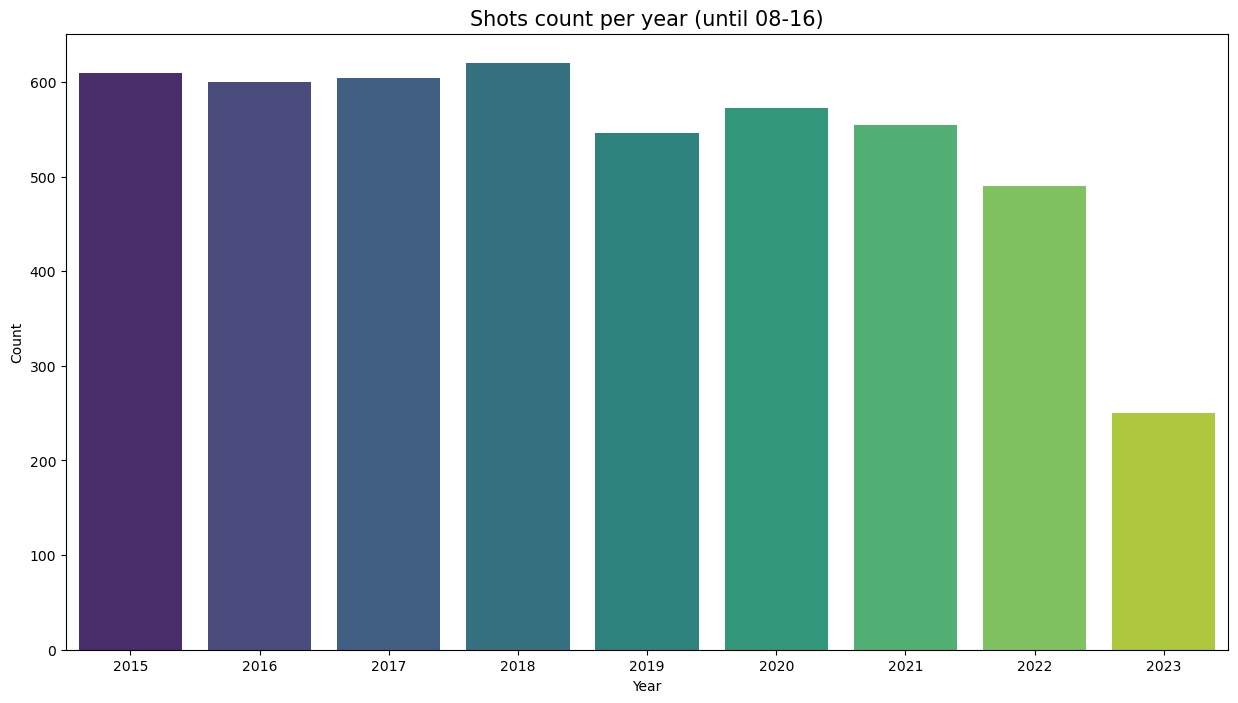

In [45]:
# Plot shots by year until 08-16
plt.figure(figsize=(15,8))
sns.countplot(x='year', data=df_years, palette='viridis')
plt.title('Shots count per year (until 08-16)', fontsize=15)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Good news! All the previous years until 08-16 had more than double cases than 2023.

We will start now to analyze further the data of shots by race according to the total population, in order to find any racial bias.

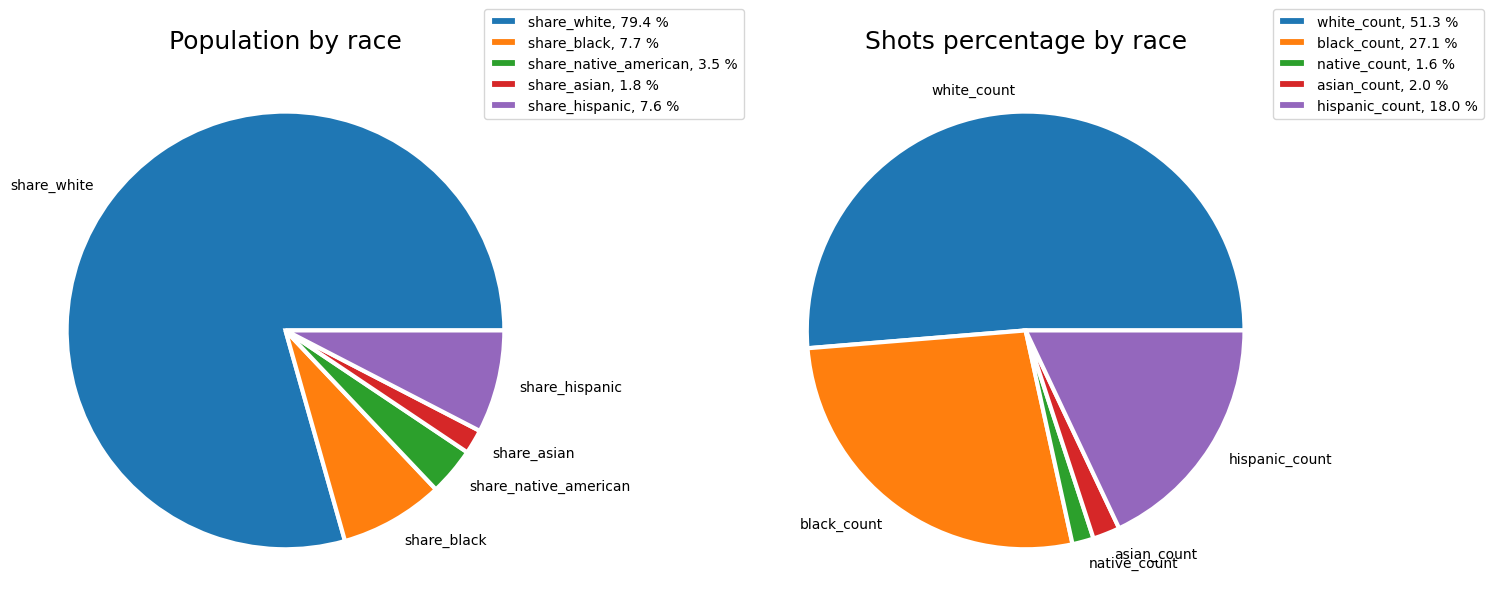

In [46]:
# Plot two subplots with population with shares and shots count by race
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

df2_mean = df2[cols].mean()
cols2 = ['white_count', 'black_count', 'native_count', 'asian_count', 'hispanic_count']
df_casesbyrace_sum = df_casesbyrace[cols2].sum()

patches, texts= ax1.pie(
    df2_mean, labels=cols, 
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'medium'})
patches2, texts2= ax2.pie(
    df_casesbyrace_sum, labels=cols2, 
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'medium'})

percents1 = df2_mean.to_numpy() * 100 / df2_mean.to_numpy().sum()
percents2 = df_casesbyrace_sum.to_numpy() * 100 / df_casesbyrace_sum.to_numpy().sum()

first_legend = ax1.legend(bbox_to_anchor=(1.35,1.1), loc='best',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(cols,percents1)])
second_legend = ax2.legend(bbox_to_anchor=(1.35,1.1), loc='best',
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(cols2,percents2)])

ax1.set_title('Population by race', fontsize=18)
ax2.set_title('Shots percentage by race', fontsize=18)
plt.tight_layout()
plt.show()

From this graph it is clear that there are some racial bias. On percentage there are too many shots for black and hispanic race, while they are too low for white race, according to the total population. The data is quite similar for native and asian races.

In [47]:
# Create a incidence rate of total count over population shares
df_casesbyrace_sum = df_casesbyrace_sum.rename({"white_count": "white", "black_count": "black", "hispanic_count": "hispanic",
                     "native_count": "native_american", "asian_count": "asian"})
df2_mean.reset_index()
df2_mean = df2_mean.rename({"share_white": "white", "share_black": "black", "share_hispanic": "hispanic",
                     "share_native_american": "native_american", "share_asian": "asian"})

incidence = pd.concat([df_casesbyrace_sum, df2_mean], axis=1)
incidence = incidence.rename(columns={0: 'total_count', 1: 'share_mean'})
incidence["incidence_count_share"] = incidence["total_count"] / incidence["share_mean"]

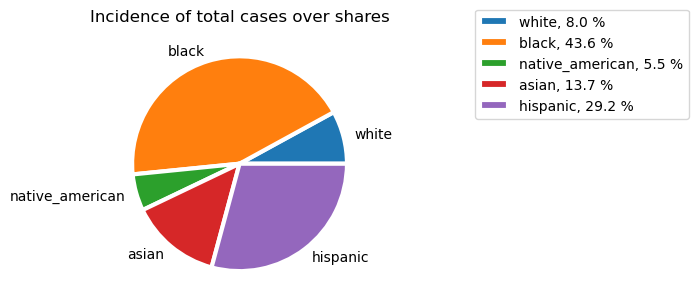

In [48]:
# Plot incidence of population over shares
cols4 = incidence.index
fig, ax = plt.subplots(figsize=(8,8))
patches, texts= ax.pie(
    incidence["incidence_count_share"], labels=cols4, 
    wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
    textprops={'size': 'medium'})

ax.set_title('Incidence of total cases over shares', fontsize=12)
percents2 = incidence["incidence_count_share"].to_numpy() * 100 / incidence["incidence_count_share"].to_numpy().sum()
plt.legend( bbox_to_anchor=(1.35,1.1), loc=2,
            labels=['%s, %1.1f %%' % (l, s) for l, s in zip(cols4,percents2)])
plt.tight_layout()

Above we have a further evidence of what is shown by comparison of Population by race and Shots count by race, calculating a incidence rate of the two dataframes. White race is almost the lowest one.

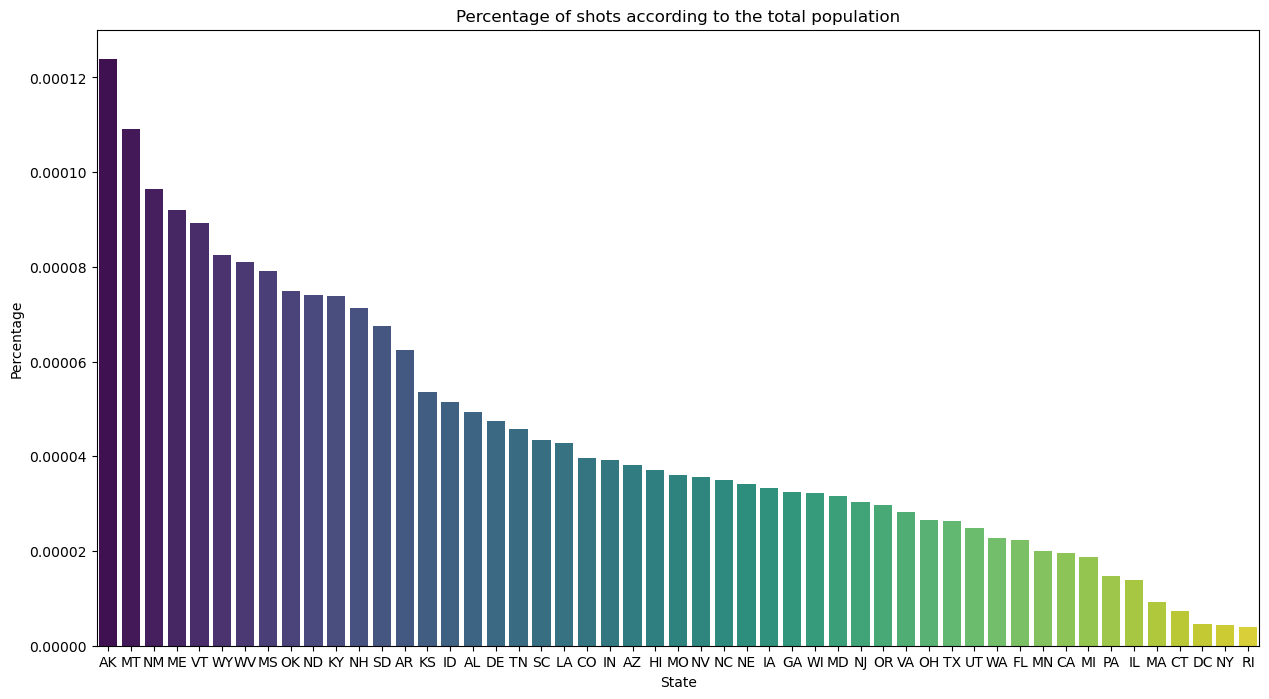

In [49]:
# Plot percentage of shots according to population
plt.figure(figsize=(15, 8))
sns.barplot(x='state', y = 'percentage', data=df_casesbyrace, palette='viridis')
plt.title('Percentage of shots according to the total population')
plt.xlabel('State')
plt.ylabel('Percentage')
plt.show()

As we can see, considering the total population everything changes. Now the most aggressive state is Alaska, followed by Montana, New Mexico, Maine and Vermont.

In [50]:
# Generate df with armed people
df_armed = df.groupby("race")["armed"].value_counts().unstack()
df_armed = df_armed.drop("unknown",axis=1)
df_armed = df_armed.apply(lambda x:(x/x.sum())*100, axis=1).round(2)
df_armed.sort_values(by=['yes'])

armed,no,yes
race,,
Other,23.81,76.19
Black,8.37,91.63
Hispanic,7.43,92.57
Native,7.34,92.66
Asian,5.88,94.12
White,5.56,94.44


The graph above says that white people owns again the lowest percentage of unarmed people. Data about other race is not reliable due to too few cases (16 yes, 5 no).

In [51]:
# Generate df with threat percentages
df_threat = df.groupby("race")["threat"].value_counts().unstack()
df_threat = df_threat.apply(lambda x:(x/x.sum())*100, axis=1).round(2)
df_threat.sort_values(by=['yes'])

threat,accident,unknown,yes
race,,,
Native,NaN,6.09,93.91
Black,0.76,3.95,95.29
Hispanic,0.99,3.13,95.87
White,0.56,3.19,96.25
Asian,NaN,2.74,97.26
Other,NaN,NaN,100.00


From the data above we can assume that Native, Black and Hispanic races have the highest percentages of shots for not sure threats. This can be a signal of racial bias.

In [52]:
# Generate df with body_camera percentages
df_body_camera = df.groupby("race")["body_camera"].value_counts().unstack()
df_body_camera = df_body_camera.apply(lambda x:(x/x.sum())*100, axis=1).round(2)
df_body_camera.sort_values(by=[True])

body_camera,False,True
race,,
White,88.03,11.97
Hispanic,84.71,15.29
Other,81.82,18.18
Native,81.74,18.26
Asian,80.14,19.86
Black,79.14,20.86


White race has highest percentage of shots with body camera off, this cannot be interpreted as a signal of racial bias.

In [53]:
# Generate df with flee percentages
df_flee = df.groupby("race")["flee_status"].value_counts().unstack()
df_flee = df_flee.drop("unknown",axis=1)
df_flee = df_flee.apply(lambda x:(x/x.sum())*100, axis=1).round(2)
df_flee.sort_values(by=['yes'])

flee_status,no,yes
race,,
Asian,74.44,25.56
White,66.47,33.53
Other,60.00,40.00
Hispanic,59.85,40.15
Native,58.76,41.24
Black,56.08,43.92


From the data above shots which involved not-fleeing people show their highest in asian race.

In [54]:
# Generate df with was_mental_illness_related percentages
df_mental_illness = df.groupby("race")["was_mental_illness_related"].value_counts().unstack()
df_mental_illness = df_mental_illness.apply(lambda x:(x/x.sum())*100, axis=1).round(2)
df_mental_illness.sort_values(by=[True])

was_mental_illness_related,False,True
race,,
Black,84.86,15.14
Native,84.35,15.65
Hispanic,83.87,16.13
Asian,77.40,22.60
White,73.16,26.84
Other,72.73,27.27


We cannot draw so many conclusions from the data above.

Let's analyze now the sociodemographic data.

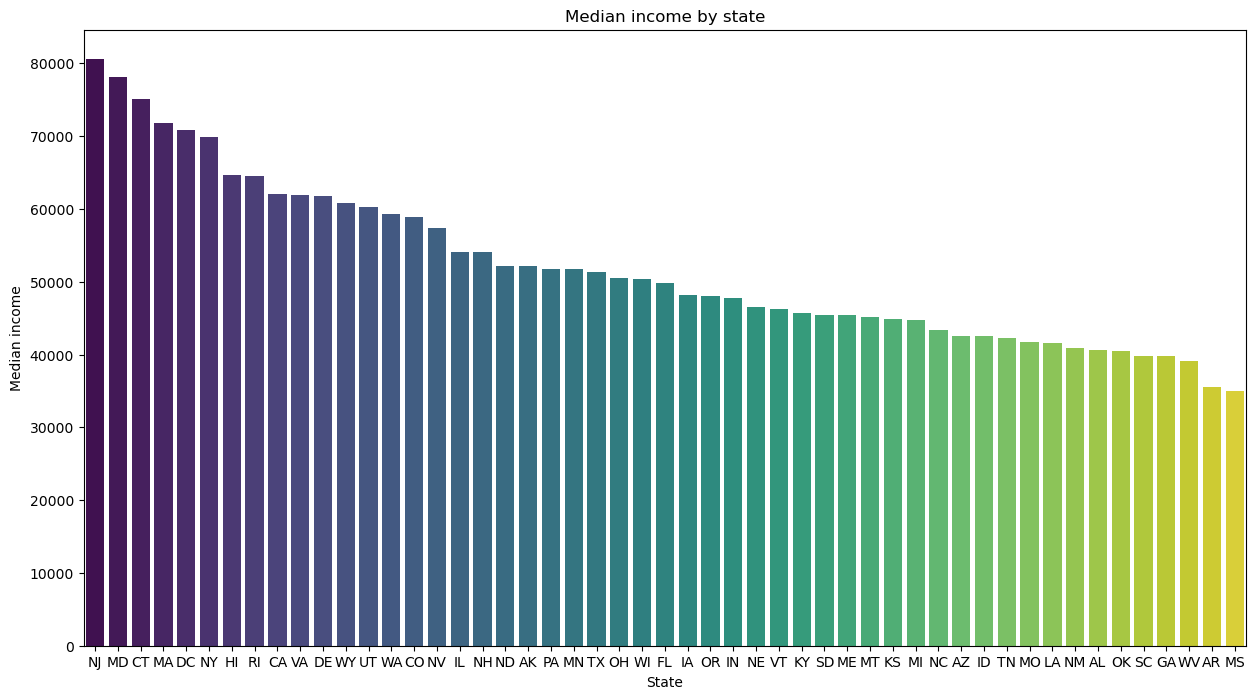

In [55]:
# Plot median income by state
df5 = df5.sort_values(['median_income'], ascending= False)
plt.figure(figsize=(15, 8))
sns.barplot(x='state', y = 'median_income', data=df5, palette='viridis')
plt.title('Median income by state')
plt.xlabel('State')
plt.ylabel('Median income')
plt.show()

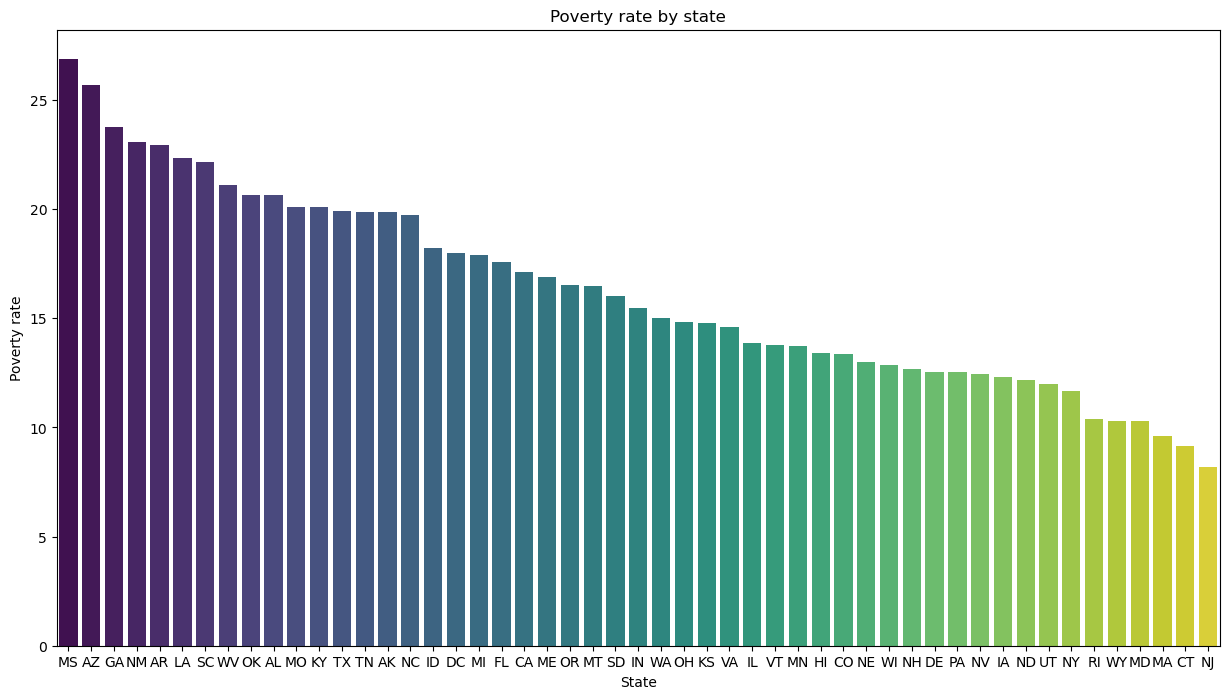

In [56]:
# Plot poverty rate by state
df5 = df5.sort_values(['poverty_rate'], ascending= False)
plt.figure(figsize=(15, 8))
sns.barplot(x='state', y = 'poverty_rate', data=df5, palette='viridis')
plt.title('Poverty rate by state')
plt.xlabel('State')
plt.ylabel('Poverty rate')
plt.show()

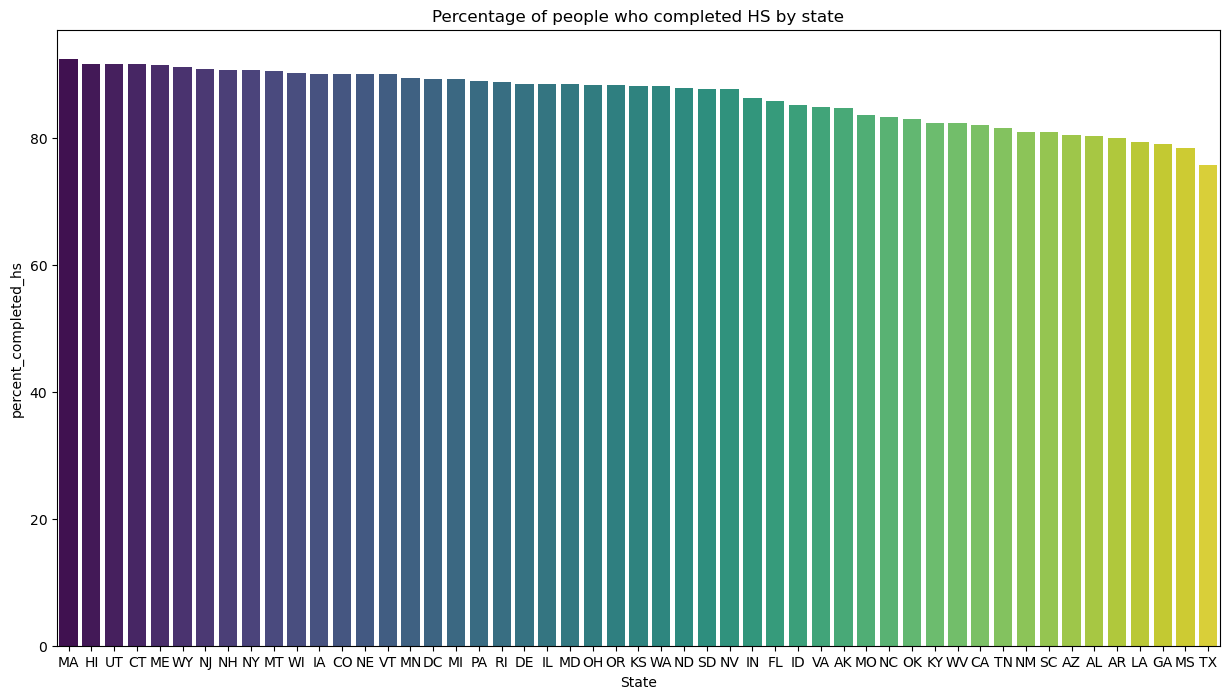

In [57]:
# Plot percentage HS by state
df5 = df5.sort_values(['percent_completed_hs'], ascending= False)
plt.figure(figsize=(15, 8))
sns.barplot(x='state', y = 'percent_completed_hs', data=df5, palette='viridis')
plt.title('Percentage of people who completed HS by state')
plt.xlabel('State')
plt.ylabel('percent_completed_hs')
plt.show()

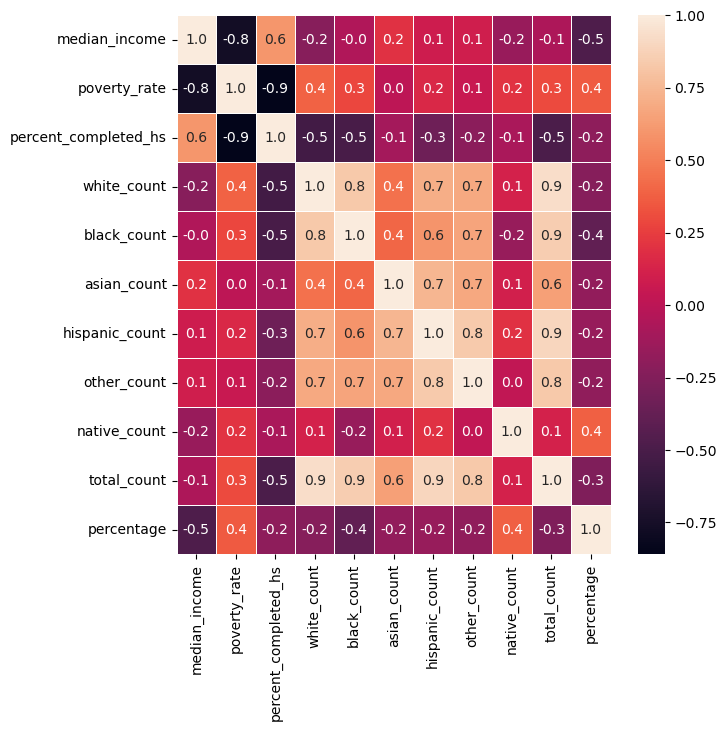

In [58]:
# Plot correlations
f,ax = plt.subplots(figsize=(7,7))
sns.heatmap(df5.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

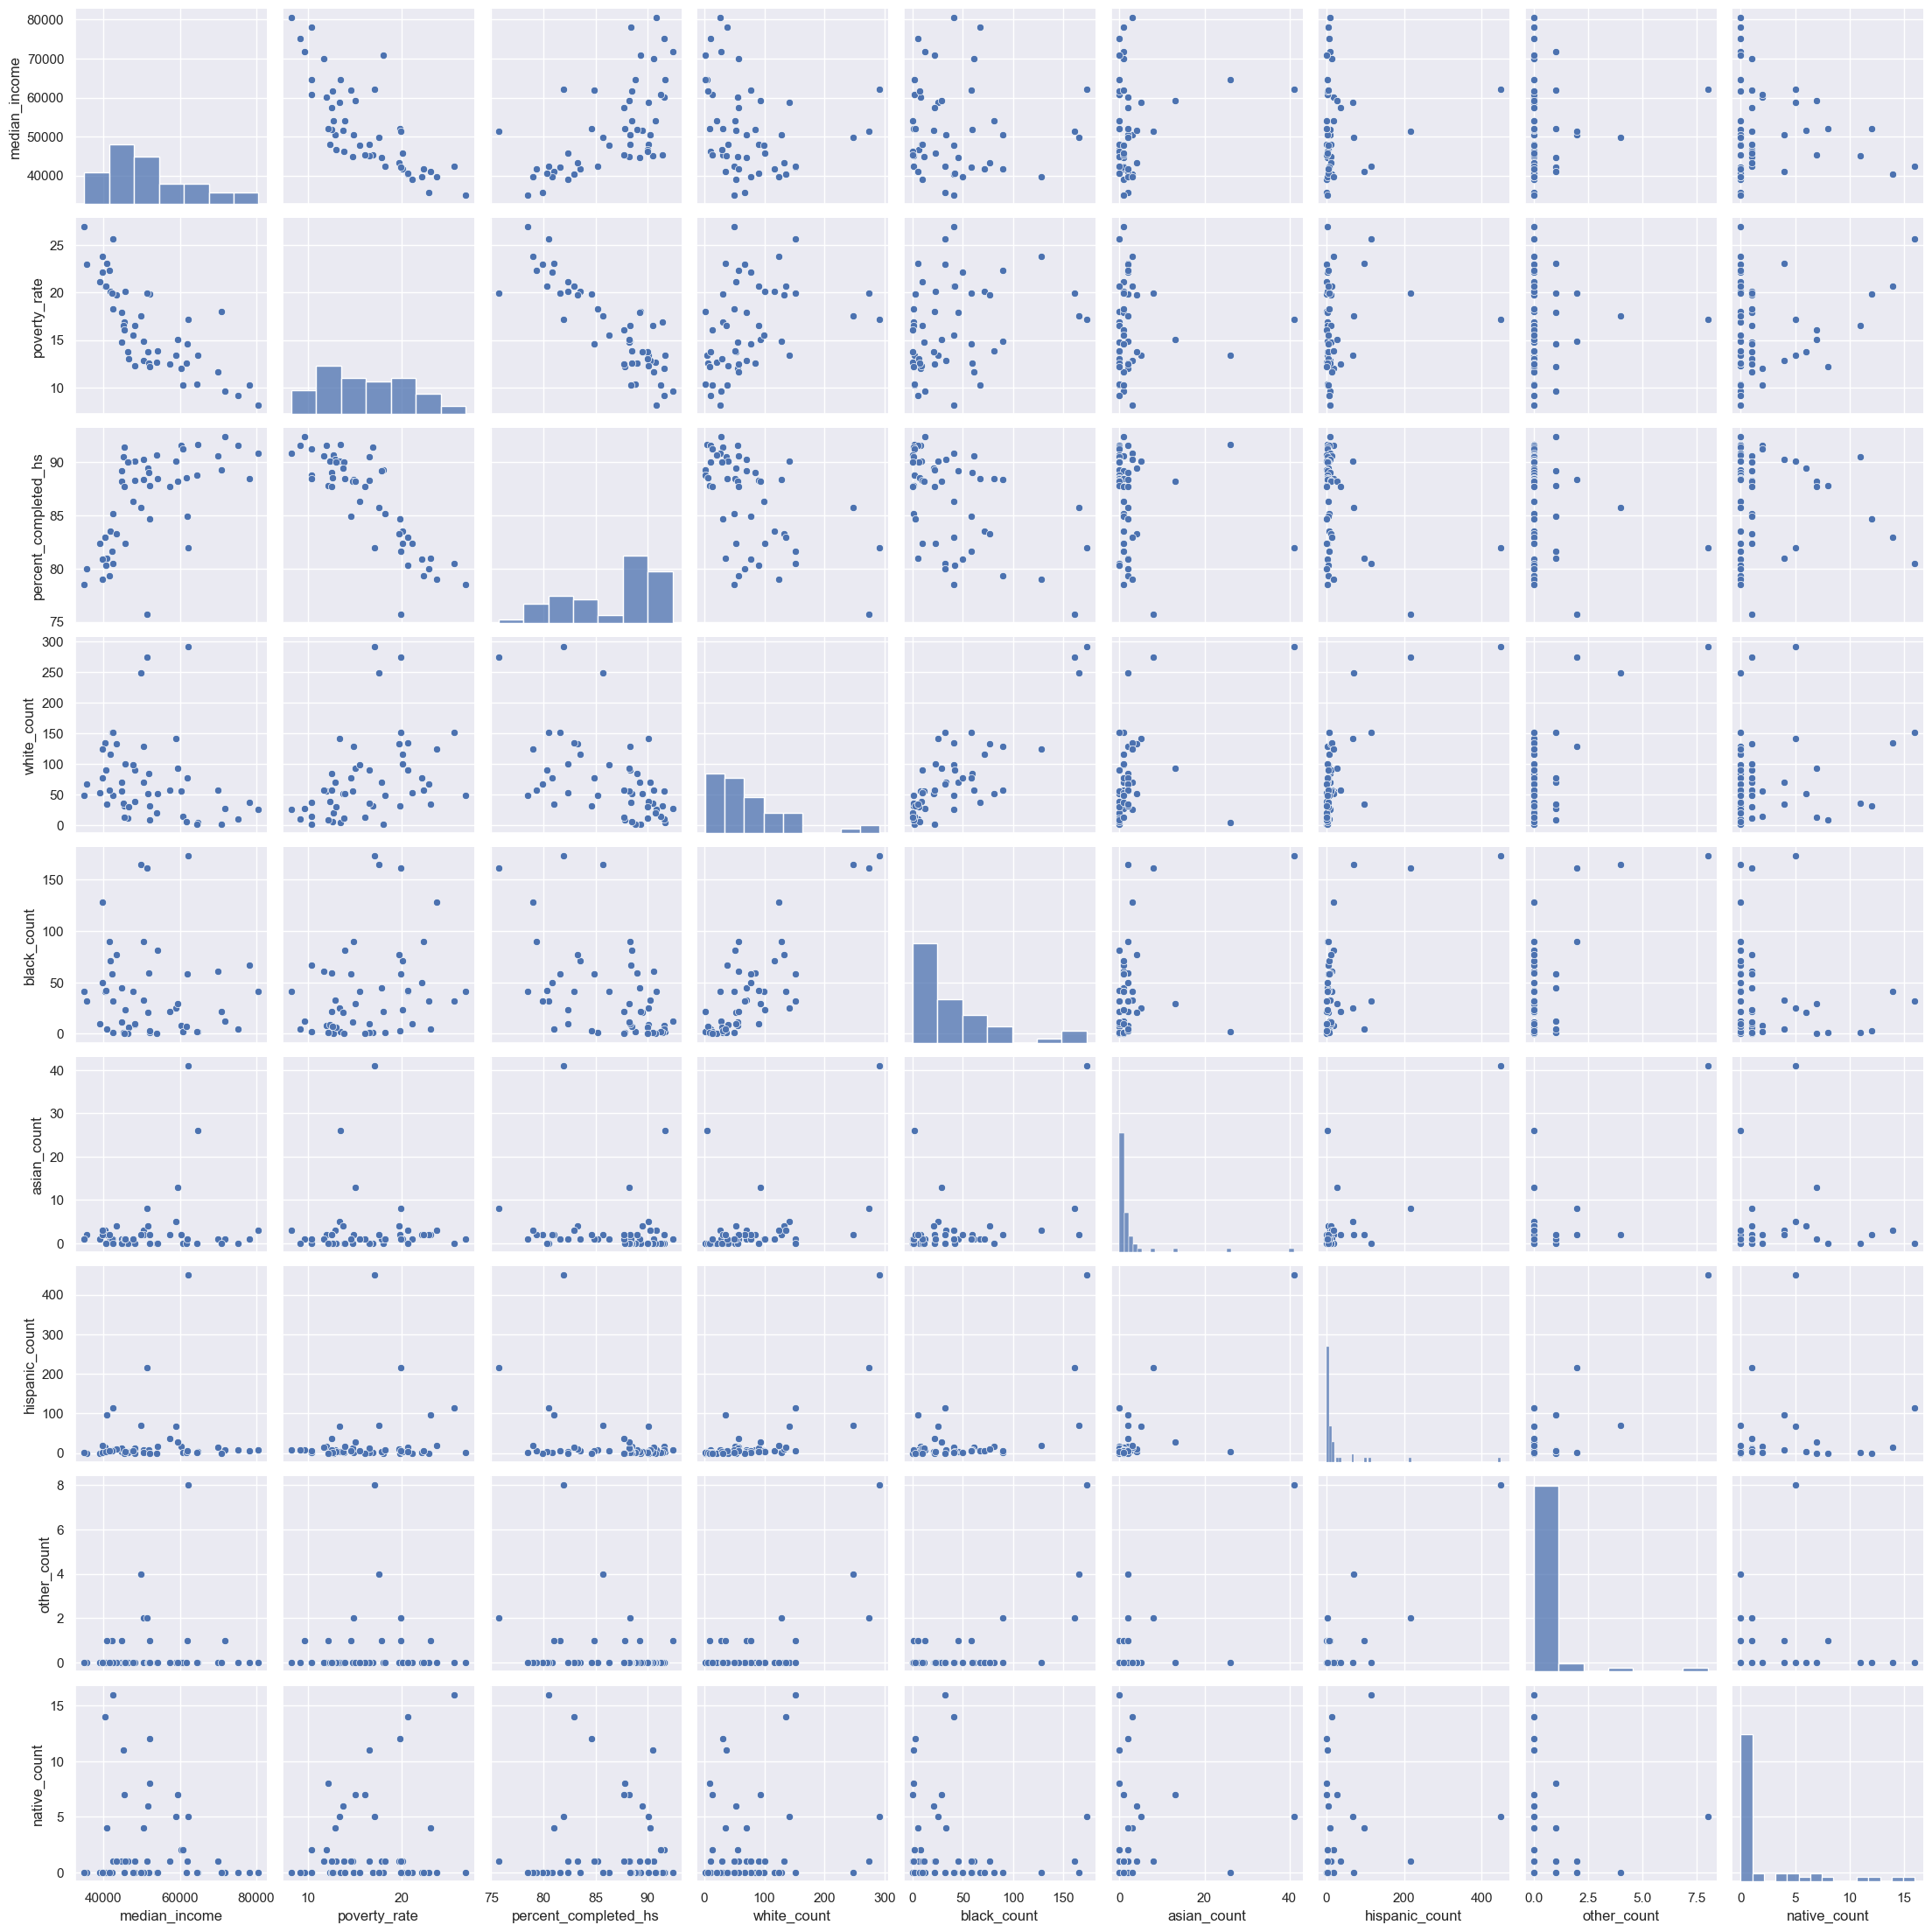

In [59]:
# Plot all correlations
sns.set()
cols6= ['median_income','poverty_rate','percent_completed_hs','white_count','black_count','asian_count','hispanic_count','other_count','native_count']
sns.pairplot(df5[cols6], size = 2.5)
plt.show()

It seems there is not correlations between races count and sociodemographic data. Let's focus just on sociodemographic data.

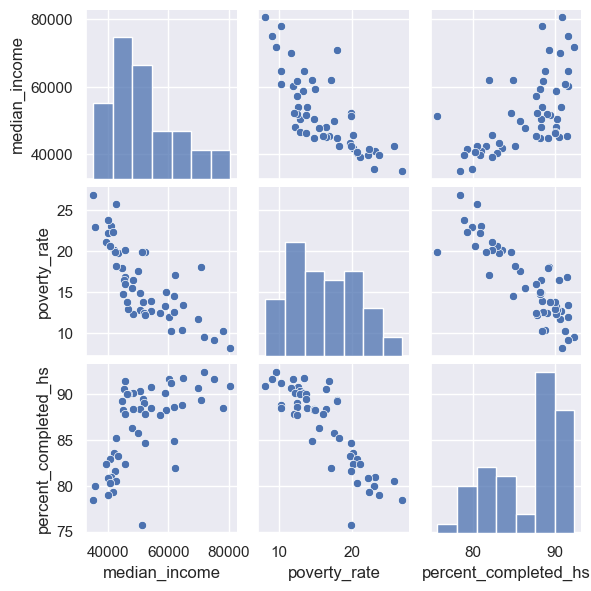

In [60]:
# Plot only sociodemographic data correlation
sns.set()
cols7= ['median_income','poverty_rate','percent_completed_hs']
sns.pairplot(df5[cols7], size = 2)
plt.show()

The median income has fairly a strong negative correlation with the poverty rate. The percentage of people who complete HS has strong positive correlation with the median income and negative with poverty rate.

## Conclusions ##

- The shots most involve males of age 37 on average. On absolute and relative terms, the most attacked race is white people, but there are several discrepancies regarding the distribution of shots according to population. 
- California, Texas, Florida, Arizona and Georgia seem to be the most aggressive states, but that's due to the large population.
- Actually, considering the percentage of shots by population, the states with the highest percentage are Alaska, Montana, New Mexico, Maine and Vermont.
- From 2015 the cases are decreasing.
- Black, hispanic and asian people are too subject to attacks in according to the total population. Indeed the incidence rate of total shots of white people according to population shares is the lowest.
- Non-white races own the highest percentages of shots against unarmed people and for not-confirmed threats. I think we can conclude saying that these minor races are victims of police harassment.
- From sociodemographic data we can say there is a strong correlation among median income, poverty rate and percentage of completed HS, but there are no many links with shots counts.